# Session 08: Yield Curves, Term Spreads, and Fed Policy

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from dotenv import load_dotenv
from datetime import datetime

# Load environment variables
load_dotenv()
fred_api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=fred_api_key)

print(f"FRED API key loaded: {fred_api_key[:10]}...")

FRED API key loaded: 1383c60c37...


## FRED Series IDs

### Treasury Yields (for Yield Curve)
- **DGS3MO**: 3-Month Treasury
- **DGS6MO**: 6-Month Treasury  
- **DGS1**: 1-Year Treasury
- **DGS2**: 2-Year Treasury
- **DGS3**: 3-Year Treasury
- **DGS5**: 5-Year Treasury
- **DGS7**: 7-Year Treasury
- **DGS10**: 10-Year Treasury
- **DGS20**: 20-Year Treasury
- **DGS30**: 30-Year Treasury

### Economic Indicators
- **T10Y3M**: 10-Year Treasury Minus 3-Month Treasury (Term Spread)
- **GDPC1**: Real Gross Domestic Product
- **DFEDTARU**: Federal Funds Target Range - Upper Limit
- **DTB6**: 6-Month Treasury Bill Rate
- **FEDFUNDS**: Effective Federal Funds Rate

### Real and Inflation-Indexed Securities
- **DFII10**: 10-Year Treasury Inflation-Indexed Security (Real Yield)
- **T5YIE**: 5-Year Breakeven Inflation Rate

In [2]:
# Fetch all treasury yield data for yield curve construction
treasury_series = {
    '3M': 'DGS3MO',
    '6M': 'DGS6MO',
    '1Y': 'DGS1',
    '2Y': 'DGS2',
    '3Y': 'DGS3',
    '5Y': 'DGS5',
    '7Y': 'DGS7',
    '10Y': 'DGS10',
    '20Y': 'DGS20',
    '30Y': 'DGS30',
}

# Fetch treasury data
treasury_data = {}
for name, series_id in treasury_series.items():
    try:
        series = fred.get_series(series_id, observation_start='1990-01-01')
        treasury_data[name] = series
        print(f"Fetched {name}: {len(series)} observations")
    except Exception as e:
        print(f"Error fetching {name} ({series_id}): {e}")

df_yields = pd.DataFrame(treasury_data)
print(f"\nYields DataFrame shape: {df_yields.shape}")
print(f"Date range: {df_yields.index.min()} to {df_yields.index.max()}")

Fetched 3M: 9399 observations
Fetched 6M: 9399 observations
Fetched 1Y: 9399 observations
Fetched 2Y: 9399 observations
Fetched 3Y: 9399 observations
Fetched 5Y: 9399 observations
Fetched 7Y: 9399 observations
Fetched 10Y: 9399 observations
Fetched 20Y: 9399 observations
Fetched 30Y: 9399 observations

Yields DataFrame shape: (9399, 10)
Date range: 1990-01-01 00:00:00 to 2026-01-08 00:00:00


In [23]:
# Fetch economic indicators
economic_series = {
    'Term Spread': 'T10Y3M',
    'Real GDP': 'GDPC1',
    'Fed Funds Target': 'DFEDTARU',
    '6M TBill': 'DTB6',
    'Fed Funds Rate': 'FEDFUNDS',
    'Real 10Y': 'DFII10',
    '5Y Breakeven': 'T5YIE',
}

economic_data = {}
for name, series_id in economic_series.items():
    try:
        series = fred.get_series(series_id, observation_start='1980-01-01')
        economic_data[name] = series
        print(f"Fetched {name}: {len(series)} observations")
    except Exception as e:
        print(f"Error fetching {name} ({series_id}): {e}")

df_econ = pd.DataFrame(economic_data)
print(f"\nEconomic DataFrame shape: {df_econ.shape}")
print(f"Date range: {df_econ.index.min()} to {df_econ.index.max()}")

## Pull and store GDP data separately since it's quarterly
gdp_series = 'GDPC1'
gdp_data = fred.get_series(gdp_series, observation_start='1980-01-01')
gdp_data.name = 'Real GDP'
gdp_data = gdp_data.resample('Q').last().dropna()

Fetched Term Spread: 11485 observations
Fetched Real GDP: 183 observations
Fetched Fed Funds Target: 6236 observations
Fetched 6M TBill: 12008 observations
Fetched Fed Funds Rate: 552 observations
Fetched Real 10Y: 6006 observations
Fetched 5Y Breakeven: 6007 observations

Economic DataFrame shape: (13890, 7)
Date range: 1980-01-01 00:00:00 to 2026-01-11 00:00:00


/var/folders/6p/l4s0yjhj757dpt1v1vj382tw0000gq/T/ipykernel_48315/1589933529.py:29: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  gdp_data = gdp_data.resample('Q').last().dropna()


## Figure 1: U.S. Treasury Term Structure at Different Points in Time

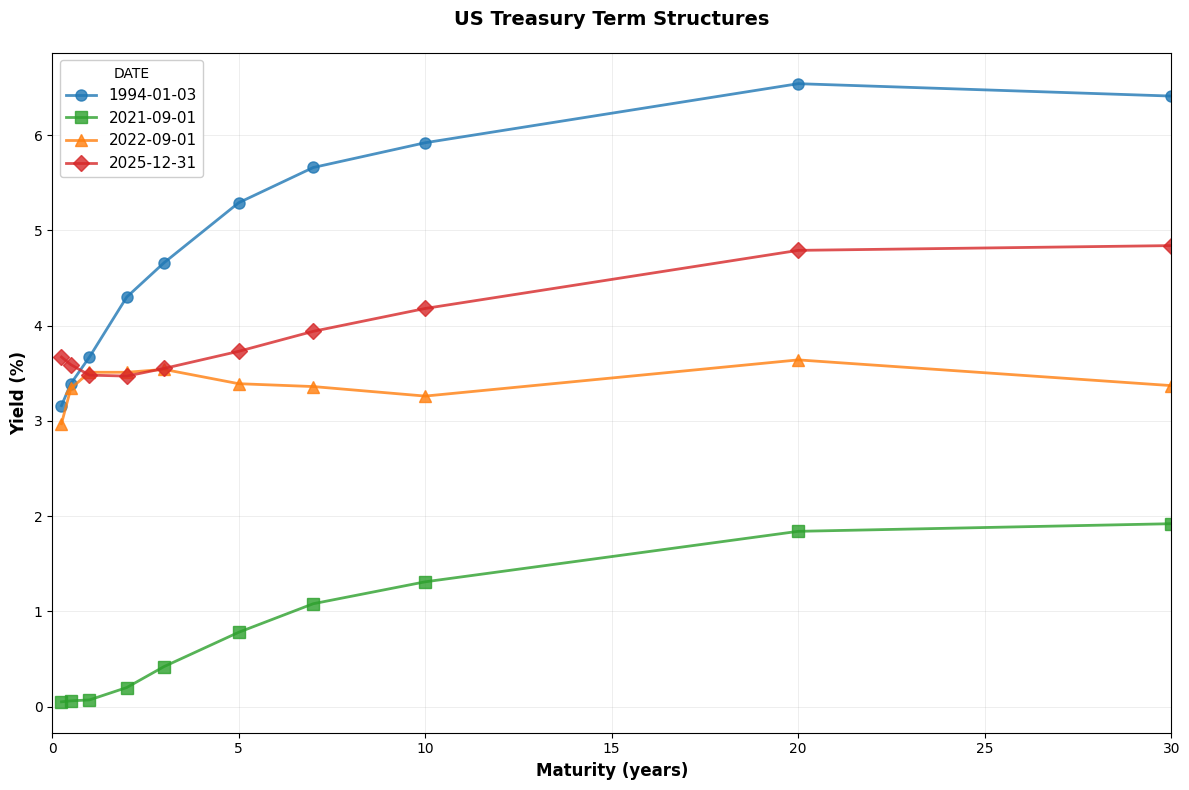

Figure saved to ../figures/yield_curve_snapshots.png


In [13]:
# Create yield curve snapshots for specific dates
# Define maturities in years for x-axis
maturities = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
maturity_labels = ['3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']

# Select specific dates to compare
dates_to_plot = [
    '1994-01-03',  # Historical reference
    '2021-09-01',  # Low rate environment
    '2022-09-01',  # Rising rates
    '2025-12-31',  # End of 2025 (or latest available)
]

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
markers = ['o', 's', '^', 'D']

for i, date in enumerate(dates_to_plot):
    try:
        # Get the closest available date
        date_idx = df_yields.index.get_indexer([pd.to_datetime(date)], method='nearest')[0]
        actual_date = df_yields.index[date_idx]
        
        # Extract yields for this date
        yields = df_yields.iloc[date_idx].values
        
        # Plot
        ax.plot(maturities, yields, 
                marker=markers[i], markersize=8,
                linewidth=2, color=colors[i],
                label=actual_date.strftime('%Y-%m-%d'),
                alpha=0.8)
    except Exception as e:
        print(f"Error plotting {date}: {e}")

# Customize plot
ax.set_xlabel('Maturity (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Yield (%)', fontsize=12, fontweight='bold')
ax.set_title('US Treasury Term Structures', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.legend(loc='best', fontsize=11, framealpha=0.95, title='DATE')
ax.set_xlim(0, 30)

plt.tight_layout()
plt.savefig('../figures/yield_curve_snapshots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/yield_curve_snapshots.png")

In [5]:
## Current Yield Curve (as of 2026-01-11)
## TO-DO

## Figure 2: Term Spread (10Y-3M) and Real GDP Growth

/var/folders/6p/l4s0yjhj757dpt1v1vj382tw0000gq/T/ipykernel_48315/3964758830.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_econ['GDP_YoY'] = df_econ['Real GDP'].pct_change(periods=252) * 100


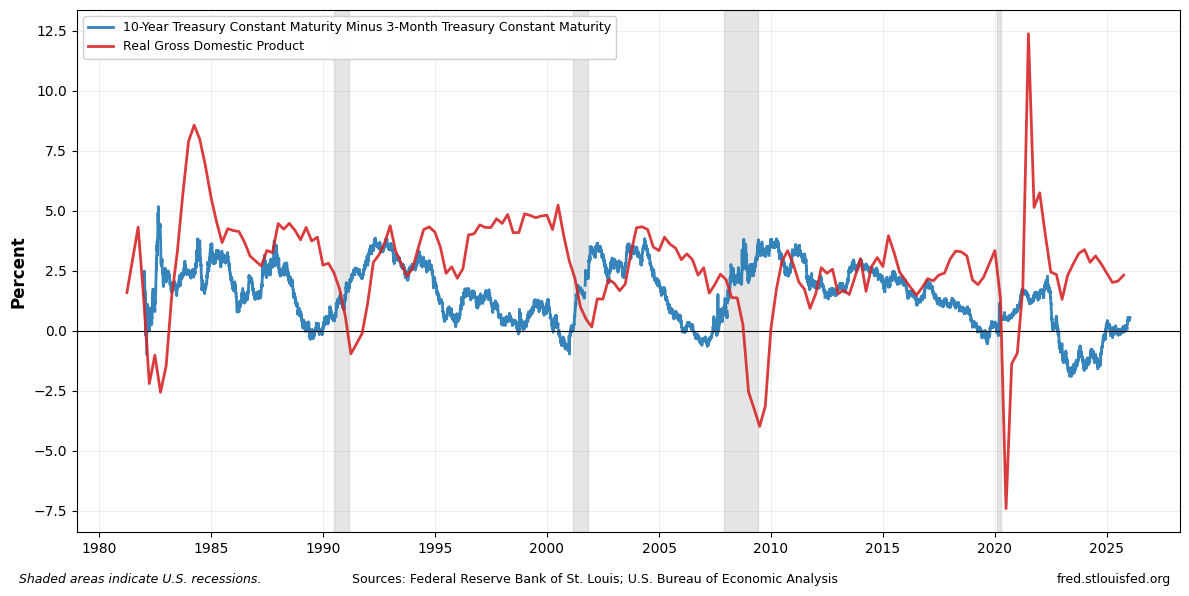

Figure saved to ../figures/term_spread_gdp.png


In [30]:
# Calculate Real GDP year-over-year percentage change
df_econ['GDP_YoY'] = df_econ['Real GDP'].pct_change(periods=252) * 100

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot term spread on primary axis
color1 = '#1f77b4'
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Percent', fontsize=12, fontweight='bold')
line1 = ax1.plot(df_econ.index, df_econ['Term Spread'], 
                 color=color1, linewidth=2, 
                 label='10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity',
                 alpha=0.9)
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)
ax1.axhline(y=0, color='black', linewidth=0.8)

## Compute year-over-year percentage change
gdp_data = pd.DataFrame(gdp_data)
gdp_data['GDP_YoY'] = gdp_data['Real GDP'].pct_change(periods=4) * 100
line2 = ax1.plot(gdp_data.index, gdp_data['GDP_YoY'], 
                 color=color2, linewidth=2,
                 label='Real Gross Domestic Product',
                 alpha=0.9)
ax2.tick_params(axis='y')

# Add recession shading
recessions = [
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01'),
]

for start, end in recessions:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                alpha=0.2, color='gray', zorder=0)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=9, framealpha=0.95)

# Add source information
fig.text(0.02, 0.02, 'Shaded areas indicate U.S. recessions.', fontsize=9, style='italic')
fig.text(0.5, 0.02, 'Sources: Federal Reserve Bank of St. Louis; U.S. Bureau of Economic Analysis', 
         fontsize=9, ha='center')
fig.text(0.98, 0.02, 'fred.stlouisfed.org', fontsize=9, ha='right')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig('../figures/term_spread_gdp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/term_spread_gdp.png")

## Figure 3: Term Spread (10Y-3M) Over Time

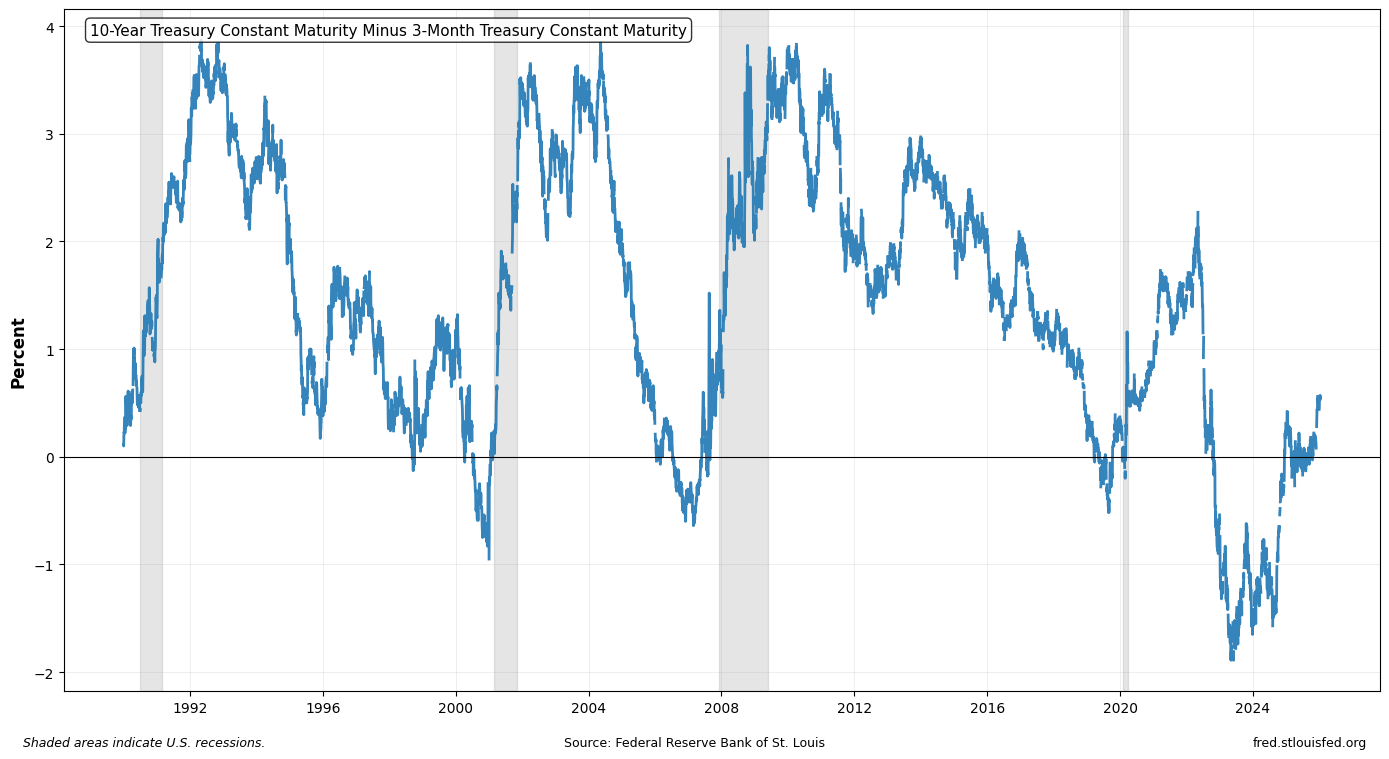

Figure saved to ../figures/term_spread.png


In [31]:
# Create figure for term spread alone
fig, ax = plt.subplots(figsize=(14, 8))

# Filter from 1990 onwards
df_spread = df_econ.loc['1990':]

# Plot term spread
ax.plot(df_spread.index, df_spread['Term Spread'], 
        color='#1f77b4', linewidth=2, alpha=0.9)

# Add recession shading
for start, end in recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
               alpha=0.2, color='gray', zorder=0)

# Customize
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Percent', fontsize=12, fontweight='bold')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Add title
title_text = '10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity'
ax.text(0.02, 0.98, title_text, 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add source
fig.text(0.02, 0.02, 'Shaded areas indicate U.S. recessions.', fontsize=9, style='italic')
fig.text(0.5, 0.02, 'Source: Federal Reserve Bank of St. Louis', fontsize=9, ha='center')
fig.text(0.98, 0.02, 'fred.stlouisfed.org', fontsize=9, ha='right')

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig('../figures/term_spread.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/term_spread.png")

## Figure 4: Federal Funds Target Rate - Upper Limit

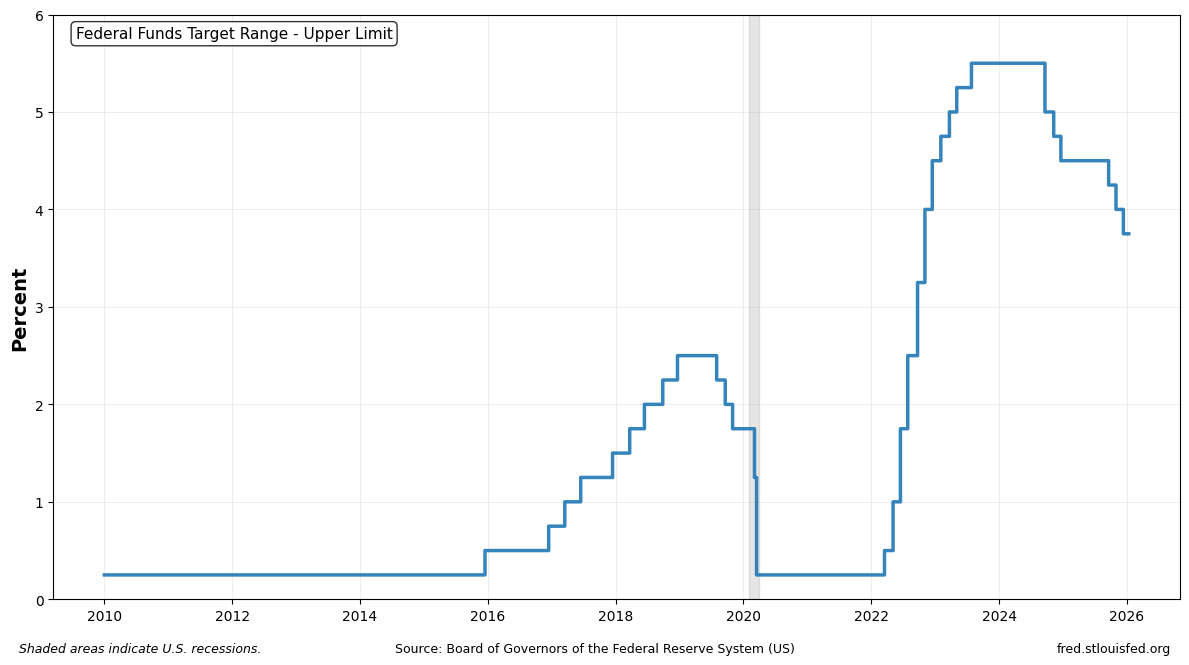

Figure saved to ../figures/fed_funds_target.png


In [33]:
# Create figure for Fed Funds Target Rate
fig, ax = plt.subplots(figsize=(12, 7))

# Filter from 2010 onwards (when target range became standard)
df_fed = df_econ.loc['2010':]

# Plot Fed Funds Target - Upper Limit
ax.plot(df_fed.index, df_fed['Fed Funds Target'], 
        color='#1f77b4', linewidth=2.5, alpha=0.9, drawstyle='steps-post')

# Add recession shading (2020 recession in this range)
ax.axvspan(pd.to_datetime('2020-02-01'), pd.to_datetime('2020-04-01'), 
           alpha=0.2, color='gray', zorder=0)

# Customize
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Percent', fontsize=14, fontweight='bold')
ax.set_ylim(0, 6)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Add title
title_text = 'Federal Funds Target Range - Upper Limit'
ax.text(0.02, 0.98, title_text, 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add source
fig.text(0.02, 0.02, 'Shaded areas indicate U.S. recessions.', fontsize=9, style='italic')
fig.text(0.5, 0.02, 'Source: Board of Governors of the Federal Reserve System (US)', fontsize=9, ha='center')
fig.text(0.98, 0.02, 'fred.stlouisfed.org', fontsize=9, ha='right')

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig('../figures/fed_funds_target.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/fed_funds_target.png")

## Figure 5: Fed Funds Rate vs 6-Month T-Bill

In [53]:
## Create a separate monthly series for fed funds rate
fed_funds_series = 'FEDFUNDS'
fed_funds_data = fred.get_series(fed_funds_series, observation_start='1980-01-01')
fed_funds_data.name = 'Fed Funds Rate'
fed_funds_data = pd.DataFrame(fed_funds_data)
fed_funds_data

,Fed Funds Rate
1980-01-01,13.82
1980-02-01,14.13
1980-03-01,17.19
1980-04-01,17.61
1980-05-01,10.98
...,...
2025-08-01,4.33
2025-09-01,4.22
2025-10-01,4.09
2025-11-01,3.88


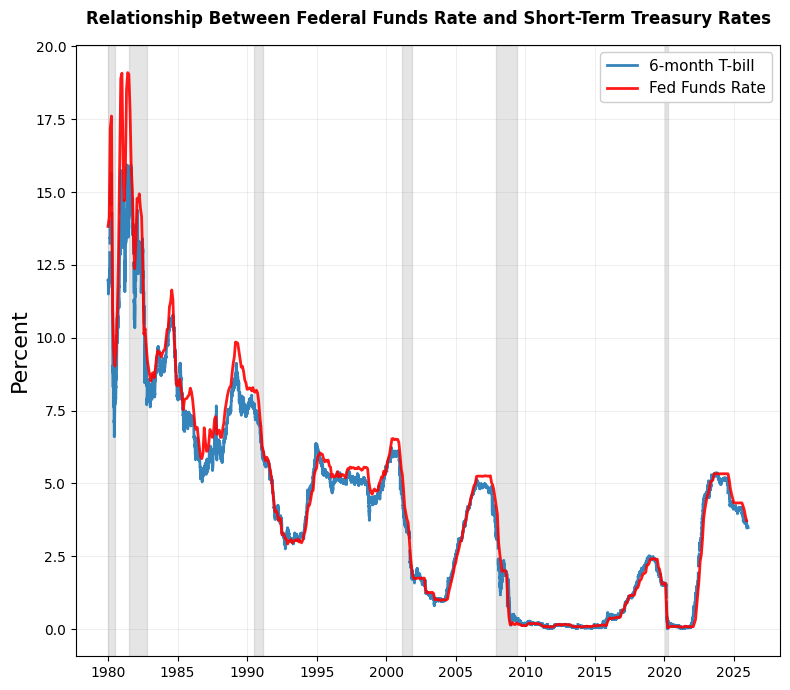

Figure saved to ../figures/fed_funds_vs_tbill.png


In [59]:
# Create figure comparing Fed Funds Rate and 6-Month T-Bill
fig, ax = plt.subplots(figsize=(8, 7))

# Filter from 1980 onwards
df_rates = df_econ.loc['1980':]

# Plot both rates
ax.plot(df_rates.index, df_rates['6M TBill'], 
        color='#1f77b4', linewidth=2, label='6-month T-bill', alpha=0.9)
ax.plot(fed_funds_data.index, fed_funds_data['Fed Funds Rate'], 
        color='red', linewidth=2, label='Fed Funds Rate', alpha=0.9)

# Add recession shading
all_recessions = [
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01'),
]

for start, end in all_recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
               alpha=0.2, color='gray', zorder=0)

# Customize
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Percent', fontsize=16)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
# ax.set_ylim(0, 17)

# Add title
title_text = 'Relationship Between Federal Funds Rate and Short-Term Treasury Rates'
ax.set_title(title_text, fontsize=12, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('../figures/fed_funds_vs_tbill.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/fed_funds_vs_tbill.png")

## Figure 6: Nominal vs Real 10-Year Treasury Yields

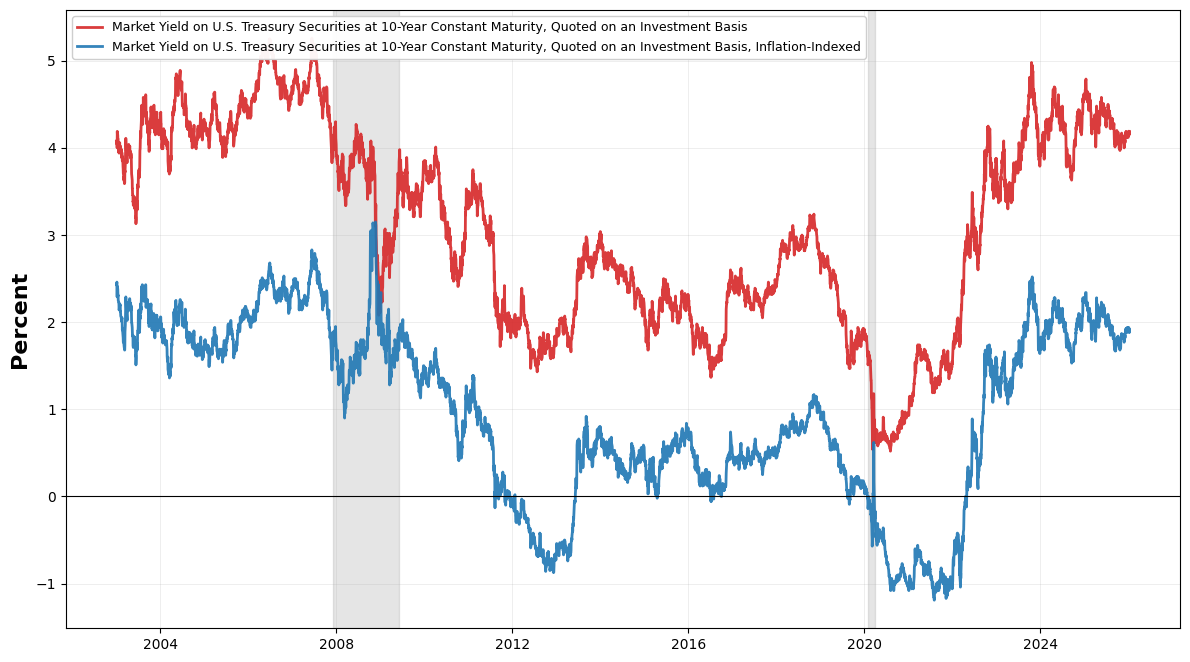

Figure saved to ../figures/nominal_vs_real_yields.png


In [62]:
# Merge nominal 10Y yield with real yield data
df_nominal_real = pd.DataFrame({
    'Nominal': df_yields['10Y'],
    'Real': df_econ['Real 10Y']
})

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

# Filter from 2003 onwards (when TIPS data becomes available)
df_plot = df_nominal_real.loc['2003':].dropna()

# Plot both yields
ax.plot(df_plot.index, df_plot['Nominal'], 
        color='#d62728', linewidth=2, 
        label='Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis',
        alpha=0.9)
ax.plot(df_plot.index, df_plot['Real'], 
        color='#1f77b4', linewidth=2,
        label='Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis, Inflation-Indexed',
        alpha=0.9)

# Add recession shading
recent_recessions = [
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01'),
]

for start, end in recent_recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
               alpha=0.2, color='gray', zorder=0)

# Customize
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Percent', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.legend(loc='upper left', fontsize=9, framealpha=0.95)

# Add source
# fig.text(0.02, 0.02, 'Shaded areas indicate U.S. recessions.', fontsize=9, style='italic')
# fig.text(0.5, 0.02, 'Source: Board of Governors of the Federal Reserve System (US)', fontsize=9, ha='center')
# fig.text(0.98, 0.02, 'fred.stlouisfed.org', fontsize=9, ha='right')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig('../figures/nominal_vs_real_yields.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/nominal_vs_real_yields.png")

## Figure 7: 5-Year Breakeven Inflation Rate

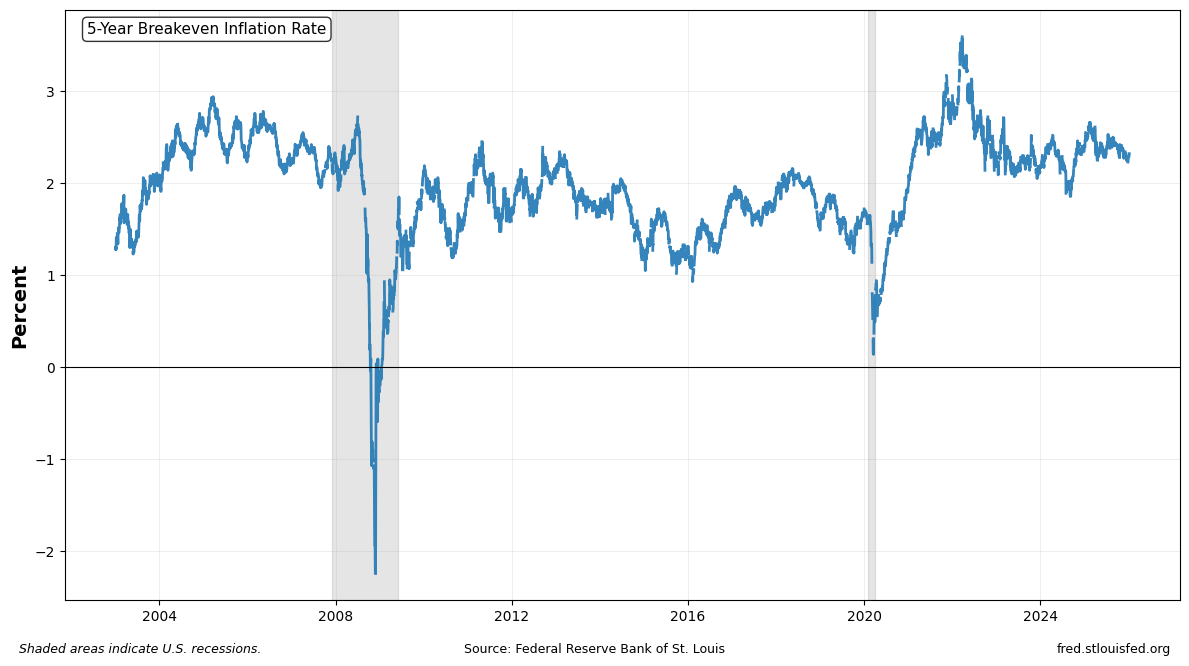

Figure saved to ../figures/breakeven_inflation.png


In [63]:
# Create figure for breakeven inflation rate
fig, ax = plt.subplots(figsize=(12, 7))

# Filter from 2003 onwards
df_breakeven = df_econ.loc['2003':]

# Plot breakeven inflation
ax.plot(df_breakeven.index, df_breakeven['5Y Breakeven'], 
        color='#1f77b4', linewidth=2, alpha=0.9)

# Add recession shading
for start, end in recent_recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
               alpha=0.2, color='gray', zorder=0)

# Customize
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Percent', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.axhline(y=0, color='black', linewidth=0.8)

# Add title
title_text = '5-Year Breakeven Inflation Rate'
ax.text(0.02, 0.98, title_text, 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add source
fig.text(0.02, 0.02, 'Shaded areas indicate U.S. recessions.', fontsize=9, style='italic')
fig.text(0.5, 0.02, 'Source: Federal Reserve Bank of St. Louis', fontsize=9, ha='center')
fig.text(0.98, 0.02, 'fred.stlouisfed.org', fontsize=9, ha='right')

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig('../figures/breakeven_inflation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/breakeven_inflation.png")

## Summary Statistics and Analysis

In [64]:
# Display summary statistics
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

print("\n1. Current Yield Curve (Latest Available):")
print("-" * 60)
latest_yields = df_yields.iloc[-1].dropna()
print(latest_yields)
print(f"\nDate: {df_yields.index[-1]}")

print("\n2. Term Spread Statistics (1990-Present):")
print("-" * 60)
spread_stats = df_econ.loc['1990':, 'Term Spread'].describe()
print(spread_stats)
print(f"\nCurrent Term Spread: {df_econ['Term Spread'].iloc[-1]:.2f}%")

print("\n3. Fed Funds Target Rate:")
print("-" * 60)
print(f"Current: {df_econ['Fed Funds Target'].iloc[-1]:.2f}%")
print(f"Date: {df_econ.index[-1]}")

print("\n4. Breakeven Inflation Expectations:")
print("-" * 60)
print(f"5-Year Breakeven Inflation: {df_econ['5Y Breakeven'].iloc[-1]:.2f}%")
print(f"Average (2003-Present): {df_econ.loc['2003':, '5Y Breakeven'].mean():.2f}%")

print("\n5. Nominal vs Real Yields:")
print("-" * 60)
nominal_current = df_yields['10Y'].iloc[-1]
real_current = df_econ['Real 10Y'].iloc[-1]
implied_inflation = nominal_current - real_current
print(f"10-Year Nominal Yield: {nominal_current:.2f}%")
print(f"10-Year Real Yield: {real_current:.2f}%")
print(f"Implied Inflation: {implied_inflation:.2f}%")

print("\n" + "=" * 80)

SUMMARY STATISTICS

1. Current Yield Curve (Latest Available):
------------------------------------------------------------
3M     3.62
6M     3.56
1Y     3.48
2Y     3.49
3Y     3.56
5Y     3.74
7Y     3.95
10Y    4.19
20Y    4.79
30Y    4.85
Name: 2026-01-08 00:00:00, dtype: float64

Date: 2026-01-08 00:00:00

2. Term Spread Statistics (1990-Present):
------------------------------------------------------------
count    9011.000000
mean        1.459385
std         1.280629
min        -1.890000
25%         0.500000
50%         1.490000
75%         2.520000
max         3.870000
Name: Term Spread, dtype: float64

Current Term Spread: nan%

3. Fed Funds Target Rate:
------------------------------------------------------------
Current: 3.75%
Date: 2026-01-11 00:00:00

4. Breakeven Inflation Expectations:
------------------------------------------------------------
5-Year Breakeven Inflation: nan%
Average (2003-Present): 1.95%

5. Nominal vs Real Yields:
-----------------------------------

## Analysis: Yield Curve Slope Changes

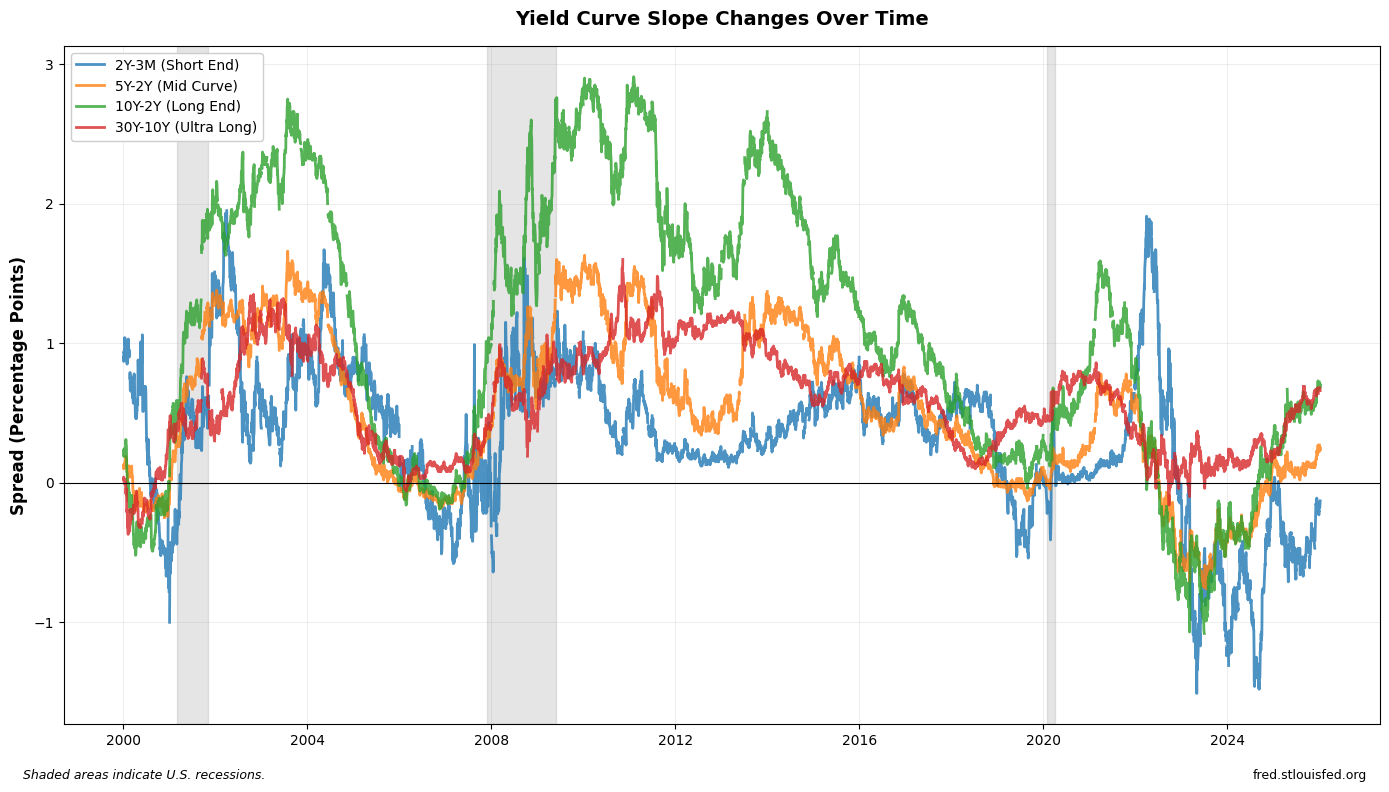

Figure saved to ../figures/yield_curve_slopes.png

Current Slope Measures:
2Y-3M     -0.13
5Y-2Y      0.25
10Y-2Y     0.70
30Y-10Y    0.66
Name: 2026-01-08 00:00:00, dtype: float64


In [65]:
# Calculate various slope measures over time
df_slopes = pd.DataFrame(index=df_yields.index)
df_slopes['2Y-3M'] = df_yields['2Y'] - df_yields['3M']
df_slopes['5Y-2Y'] = df_yields['5Y'] - df_yields['2Y']
df_slopes['10Y-2Y'] = df_yields['10Y'] - df_yields['2Y']
df_slopes['30Y-10Y'] = df_yields['30Y'] - df_yields['10Y']

# Create figure showing different slope measures
fig, ax = plt.subplots(figsize=(14, 8))

# Plot from 2000 onwards
df_plot_slopes = df_slopes.loc['2000':]

ax.plot(df_plot_slopes.index, df_plot_slopes['2Y-3M'], 
        label='2Y-3M (Short End)', linewidth=2, alpha=0.8)
ax.plot(df_plot_slopes.index, df_plot_slopes['5Y-2Y'], 
        label='5Y-2Y (Mid Curve)', linewidth=2, alpha=0.8)
ax.plot(df_plot_slopes.index, df_plot_slopes['10Y-2Y'], 
        label='10Y-2Y (Long End)', linewidth=2, alpha=0.8)
ax.plot(df_plot_slopes.index, df_plot_slopes['30Y-10Y'], 
        label='30Y-10Y (Ultra Long)', linewidth=2, alpha=0.8)

# Add recession shading
recent_recessions_2000 = [
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01'),
]

for start, end in recent_recessions_2000:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
               alpha=0.2, color='gray', zorder=0)

# Customize
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Spread (Percentage Points)', fontsize=12, fontweight='bold')
ax.set_title('Yield Curve Slope Changes Over Time', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.legend(loc='upper left', fontsize=10, framealpha=0.95)

# Add source
fig.text(0.02, 0.02, 'Shaded areas indicate U.S. recessions.', fontsize=9, style='italic')
fig.text(0.98, 0.02, 'fred.stlouisfed.org', fontsize=9, ha='right')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig('../figures/yield_curve_slopes.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to ../figures/yield_curve_slopes.png")
print("\nCurrent Slope Measures:")
print(df_slopes.iloc[-1])